# Plot Global Average of Hydrological Variables

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import importlib
import string

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
input_dir = '~/data/wifi-aus/statistics/'

dset = xr.open_dataset( f'{input_dir}/hydrovars-by-latitude.nc')

## Plotting

### Relative Water Vars

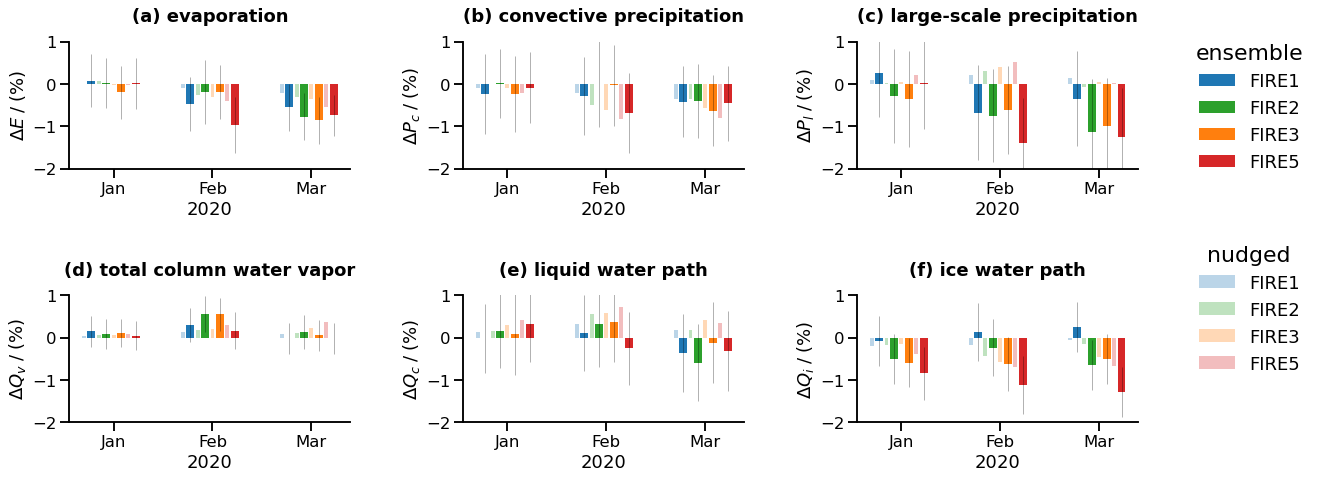

In [6]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,7))
plt.subplots_adjust( wspace = 0.4, hspace = 1., right = 0.8)
axs = axs.flatten()

abc = string.ascii_lowercase

vlist = ['evap', 'aprc', 'aprl', 'qvi', 'xlvi', 'xivi']
labellist = ['E', 'P_c', 'P_l', 'Q_v', 'Q_c', 'Q_i']
titlelist = ['evaporation', 'convective precipitation', 'large-scale precipitation',
             'total column water vapor', 'liquid water path', 'ice water path']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True, relative = True)
    axs[i].set_ylabel('$\Delta %s\;/\;(%s)$' % (labellist[i], '\%'))
    
    axs[i].set_title('(%s) %s' % (abc[i], titlelist[i]), fontweight = 'bold', pad = 20)
    axs[i].set_ylim(-2,1)


allhandles, alllabels = axs[0].get_legend_handles_labels()

for m, month in enumerate(['ensemble', 'nudged',]):
    
    axl = fig.add_axes([0.82, 0.55 - 0.4*m, 0.1, 0.4])
    m1 = 4*m
    m2 = 4*(m+1)
    handles = allhandles[m1: m2]
    labels  = alllabels[m1: m2]
        
    nlabels = plot.standardize_firenames( labels )
    axl.legend(handles, nlabels, loc = 'center',  ncol=1, fontsize = 18, title = month, title_fontproperties = {'weight':'normal', 'size': 22} )
    axl.axis('off')



plt.savefig('../pics/hydro-vars.png', dpi = 600)

### Only Plot Feb-Mar Average 

In [7]:
d_ave_fm = dset.sel(time = slice('2020-02', '2020-03')).mean('time')

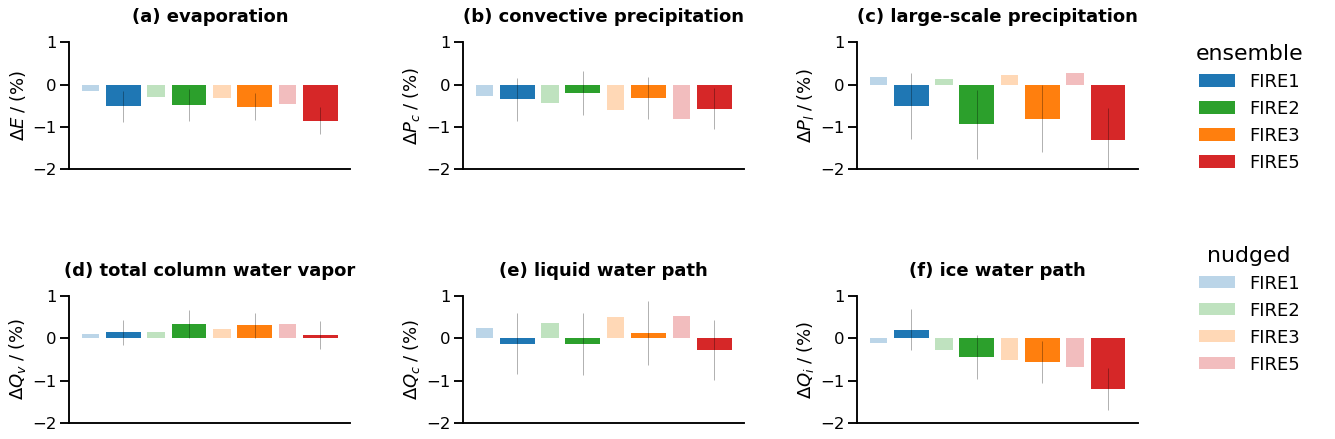

In [8]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,7))
plt.subplots_adjust( wspace = 0.4, hspace = 1., right = 0.8)
axs = axs.flatten()

abc = string.ascii_lowercase

vlist = ['evap', 'aprc', 'aprl', 'qvi', 'xlvi', 'xivi']
labellist = ['E', 'P_c', 'P_l', 'Q_v', 'Q_c', 'Q_i']
titlelist = ['evaporation', 'convective precipitation', 'large-scale precipitation',
             'total column water vapor', 'liquid water path', 'ice water path']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ave(d_ave_fm[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True, relative = True)
    axs[i].set_ylabel('$\Delta %s\;/\;(%s)$' % (labellist[i], '\%'))
    
    axs[i].set_title('(%s) %s' % (abc[i], titlelist[i]), fontweight = 'bold', pad = 20)
    axs[i].set_ylim(-2,1)
    axs[i].set_xticks([])


allhandles, alllabels = axs[0].get_legend_handles_labels()

for m, month in enumerate(['ensemble', 'nudged',]):
    
    axl = fig.add_axes([0.82, 0.55 - 0.4*m, 0.1, 0.4])
    m1 = 4*m
    m2 = 4*(m+1)
    handles = allhandles[m1: m2]
    labels  = alllabels[m1: m2]
        
    nlabels = plot.standardize_firenames( labels )
    axl.legend(handles, nlabels, loc = 'center',  ncol=1, fontsize = 18, title = month, title_fontproperties = {'weight':'normal', 'size': 22} )
    axl.axis('off')




### Calculate Rescaled Anomalies 

In [9]:
d_ave_fm['P_tot'] = d_ave_fm['aprc'] + d_ave_fm['aprl']

In [10]:
nens = 36

print('varname  |  diff / %  |  sem /  %')
for vname in vlist + ['P_tot',]:
    v = analysis.glob_mean( d_ave_fm[vname] )
    vens = ens_stat( v )
    vref = vens.sel( stats = 'reference' )
    
    vdiff = 100 * vens.sel(stats = 'mean') / vref

    scale = xr.ones_like( vdiff.mode )
    scale[:] = np.array( [1,2,3,5] )
    vdiff_rescaled = vdiff / scale

    # confidence
    var = vens.sel( stats = 'variance')
    var_rescaled = var / scale**2
    
    sem = np.sqrt( 2 * var_rescaled.mean('mode') / nens )
    sem_rel = 100. * sem / np.abs( vref.mean('mode') )
    
#    print(vname, vdiff_rescaled.data,)
    print(vname, vdiff_rescaled.mean('mode').data, sem_rel.data )

varname  |  diff / %  |  sem /  %
evap [-0.27460824] [0.15158443]
aprc [-0.16666455] [0.21202575]
aprl [-0.37698224] [0.32985996]
qvi [0.107003] [0.12743351]
xlvi [-0.05250941] [0.30423532]
xivi [-0.11261992] [0.20604892]
P_tot [-0.24003727] [0.13205125]
